# ghg_analytics
## Insights into trends with global greenhouse gases and climate change action.

EPA1333 – Computer Engineering for Scientific Computing Final Project

### Authors
Group 6:
* Aashna Mittal
* Gamze Ünlü
* Jason R Wang

## Executive Summary

In this analysis, we analyzed the implications of United Nations Framework Convention on Climate Change (UNFCCC) member states' Nationally Determined Contributions (NDCs). We compared their NDCs, firstly, emission targets set out by the 2015 Paris Agreement, and secondly with their current and historical greenhouse gas emissions. We also examined countries' contributions to the Green Climate Fund.

_Brief analysis of what we found: which countries are doing well? Which countries need to do more?_

## Introduction

Anthropogenic climate change was first introduced into the global political arena as the United Nations Framework on Climate Change Convention (UNFCCC) in 1992. Since then, other international agreements have continued to refine mitigation action. The [United Nations Sustainable Development Goal 13](https://sustainabledevelopment.un.org/sdg13), 'Take urgent action to combat climate change and its impacts*', specifically targets this global issue.

At 19th Conference of the Parties (to the UNFCCC) in 2013 in Warsaw, the UNFCCC members agreed to submit "Intended Nationally Determined Contributions" (INDCs) to signal what each country's greenhouse gas emission targets would be. At the 21st Conference in 2015, the Paris Agreement formalized these _intended_ emissions into simply "Nationally Determined Contributions" (NDCs).

Furthermore, the signatories to the Paris Agreement (which includes all UNFCCC signatories, and therefore, all UN member nations) have agreed to maintain global warming to 2ºC, but preferrably 1.5ºC, above pre-industrial levels. This Notebook intends to analyze the NDCs to estimate their potential to reach these temperature goals.

For some nations, these NDCs set a net reduction. For industrializing nations, they are simply lower than a calculated 'business-as-usual' (BAU) scenario.

![](https://i.imgur.com/mHjPRPo.png)

## Methodology

Describe methodology here!

In [1]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import NaN
plt.style.use('ggplot')

## 1. NDCs and Temperature Targets

To determine the impact of NDCs, we need to first understand their context by answering the following questions:
1. What do global emissions look like today? (and what datasets can we rely on?)
2. If nothing changes, and the world continues doing _business as usual_ (BAU), how will the world look like in 2030?

Then, we can examine how NDCs compare:
3. If all NDCs are met, what will the total amount of emissions be?
4. What emission amounts are required to meet temperature targets?

Finally, all of this will be compared in 1.5.

_Note: Emissions are quantified in units of 'megatons of carbon dioxide-equivalent per year' [MtCO2e/yr] because the strength all greenhouse gases are measured relative to carbon dioxide and because the carbon cycle is a process. Global climate targets assume that natural GHG uptake will continue steadily, so reducing the rate of emissions from countries will lead to a net decrease in the concentration of GHGs in the atmosphere._

### 1.1 Current Greenhouse Gas Emissions

Many organizations maintain databases of current (and historical) GHG emissions. The primary data source for most of them is from the UNFCCC's reporting window; each UNFCCC member submits annual 'GHG Inventories', which track national emissions with two-year delay.

The World Bank, the World Resources Institute, and the Potsdam Institute for Climate all have published datasets based on varying methodology. Below is an explanation of our approach to finding a valid set to perform further analysis on.

First examine WB data since it is most conveniently accessible and matches other easily-comparable datasets. The WB set records GHG information in _ktCO2e_, includes natural emissions, and has data from 1970-2012 and uses global warming potentials from the IPCC AR2 report.
    
Source: https://data.worldbank.org/indicator/EN.ATM.GHGT.KT.CE?view=chart

In [2]:
# Import World Bank data on GHGs
ghgDf_WB = pd.read_csv("data/GreenhouseGasData.csv", sep=',', skipinitialspace=True, skiprows=4, index_col=1) 

# Drop the indicator name and indicator code as the values are same across the whole dataframe
ghgDf_WB = ghgDf_WB.drop(["Indicator Code", "Indicator Name"], axis = 1)

# Drop all the columns that contain only null values
ghgDf_WB.dropna(axis = 1, how="all", inplace=True)  

# Drop all the rows that contain only null values, starting from column 2
ghgDf_WB.dropna(axis = 0, how="all", subset = ghgDf_WB.columns[2:], inplace= True)  

# Interpolate missing values and then use backfill to fill starting NA values of a row
ghgDf_WB.iloc[:,2:] = ghgDf_WB.iloc[:,2:].interpolate(axis = 1).bfill(axis=1)

# Convert all emissions data into MtCO2e
ghgDf_WB.iloc[:,1:] = ghgDf_WB.iloc[:,1:].divide(1000)

In [3]:
# View the cleaned WB GHG DataFrame
ghgDf_WB.head()

,Country Name,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
Country Code,,,,,,,,,,,,,,,,,,,,,
ABW,Aruba,0.042306,0.042787,0.043287,0.043725,0.044131,0.044482,0.131634,0.135055,0.358990,...,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929,0.616929
AFG,Afghanistan,14.306616,14.391778,13.040848,13.535754,14.945968,14.574164,14.746851,15.247281,15.112318,...,14.709884,14.654374,14.770264,14.849159,15.272633,15.288776,15.554429,17.791330,17.981307,18.168860
AGO,Angola,60.648601,39.162171,42.205651,44.252669,40.179234,44.429300,38.448024,43.563412,46.235115,...,35.858015,36.860233,35.855738,36.375822,36.690534,37.396294,38.309465,40.029392,40.878652,41.657165
ALB,Albania,6.960868,6.950036,7.613266,7.348492,7.632664,7.873037,8.470978,8.948981,9.996056,...,7.834016,7.401102,8.308386,8.027150,9.879394,8.136785,8.108812,8.506996,8.712296,8.898641
ARB,Arab World,552.362062,576.946152,625.015944,699.280217,679.448006,683.966235,775.863730,799.971041,827.155739,...,1963.193015,1660.586949,1767.878645,1731.288792,2355.481347,2364.088663,2387.502011,1924.244973,2483.349104,1908.696042


We create a dictionary for simplicity with key as country codes and values as the country names. Since the World Bank's naming scheme matches the [ISO-3166-1 standard](https://en.wikipedia.org/wiki/ISO_3166-1) for country names and country codes, it will be used as the reference list.

In [4]:
countryDictionary = dict( ghgDf_WB.reset_index().set_index('Country Code').iloc[:,0] )
list(countryDictionary.items())[:5]

[('ABW', 'Aruba'),
 ('AFG', 'Afghanistan'),
 ('AGO', 'Angola'),
 ('ALB', 'Albania'),
 ('ARB', 'Arab World')]

Interestingly, the World Bank's data spans from 1970 to 2012. The CAIT greenhouse gas data spans 1990 to 2014. It would be interesting to see as large a temporal range as possible. Note that the UNFCCC started recording emissions data from 1990.

The CAIT Excel workbook also contains another sheet with total CO2 emissions from 1850 to 2014. This may also be interesting for analysis.

In [5]:
# For both sets, use the ISO code as the index because it follows the ISO-3166 standard, unlike the country names!
# GHGs from 2013 and 2014
ghgDf_CAITghg = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017_ISO.xlsx",
                               sep=',', sheet_name='GHG Emissions', skipinitialspace=True, skiprows=1, index_col=1)

# CO2 emissions from 1850
ghgDf_CAITco2 = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017_ISO.xlsx",
                               sep=',', sheet_name='CO2 Total Emissions', skipinitialspace=True, index_col=1).dropna()

In [6]:
ghgDf_CAITghg.head()

,Country,Year,Total GHG Emissions Excluding Land-Use Change and Forestry (MtCO2e),Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍),Total CO2 (excluding Land-Use Change and Forestry) (MtCO2),Total CH4 (MtCO2e),Total N2O (MtCO2e),Total F-Gas (MtCO2e),Total CO2 (including Land-Use Change and Forestry) (MtCO2),Total CH4 (including Land-Use Change and Forestry) (MtCO2e),...,Industrial Processes (MtCO2e),Agriculture (MtCO2e),Waste (MtCO2e),Land-Use Change and Forestry (MtCO2),Bunker Fuels (MtCO2),Electricity/Heat (MtCO2),Manufacturing/Construction (MtCO2),Transportation (MtCO2),Other Fuel Combustion (MtCO2e),Fugitive Emissions (MtCO2e)
ISO,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,1990,15.212848,15.212848,2.915024,9.311589,2.984055,0.002180,2.915024,9.311589,...,0.057140,7.342710,4.038954,0.0,NaN,NaN,NaN,NaN,NaN,1.242220
AFG,Afghanistan,1991,15.286439,15.286439,2.684445,9.516187,3.082194,0.003613,2.684445,9.516187,...,0.058573,7.631027,4.220036,0.0,NaN,NaN,NaN,NaN,NaN,1.020851
AFG,Afghanistan,1992,14.010531,14.010531,1.392269,9.571483,3.041733,0.005046,1.392269,9.571483,...,0.063670,7.631443,4.401118,0.0,NaN,NaN,NaN,NaN,NaN,0.602588
AFG,Afghanistan,1993,14.028118,14.028118,1.322704,9.609869,3.089066,0.006479,1.322704,9.609869,...,0.065103,7.702742,4.582200,0.0,NaN,NaN,NaN,NaN,NaN,0.413993
AFG,Afghanistan,1994,13.985408,13.985408,1.267744,9.789039,2.920713,0.007912,1.267744,9.789039,...,0.066536,7.699139,4.763283,0.0,NaN,NaN,NaN,NaN,NaN,0.247331


But since we already have a large set of World Bank greenhouse gas data, we shall first attempt to append the CAIT greenhouse gas data onto it. To do so, we must filter, clean, and structure the 2013 and 2014 years that we want and the section that we want into the same format that the World Bank uses.

In [7]:
ghgDf_CAITghg1314 = ghgDf_CAITghg[ (ghgDf_CAITghg['Year'] == 2013) | (ghgDf_CAITghg['Year'] == 2014) ]\
    .loc[:,['Year','Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)']]

# Pivot the table to be in the same format as the World Bank data, which is in a nicer format
# (since we are only looking at total emissions).
ghgDf_CAITghg1314 = ghgDf_CAITghg1314.pivot(columns='Year',
                  values='Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)')

ghgDf_CAITghg1314.head()

Year,2013,2014
ISO,,
AFG,33.170920,33.366148
AGO,270.339084,252.092930
ALB,8.199265,8.678753
AND,0.509704,0.496379
ARE,218.569933,221.294487


Before we merge the datasets, it is important to see how the two sets of data might align. Do the countries match? Are the greenhouse gases quantified in the same way?

In [8]:
# These countries are in CAIT data but not the World Bank's:
ghgDf_CAITghg.loc[ ghgDf_CAITghg1314.index[~ghgDf_CAITghg1314.index.isin(ghgDf_WB.index)], 'Country' ].unique()

array(['Andorra', 'Cook Islands', 'European Union (28)', 'Liechtenstein',
       'Montenegro', 'Niue', 'Nauru', 'Palau', 'Serbia', 'World'],
      dtype=object)

In [9]:
# These countries are in World Bank data but not CAIT's:
[countryDictionary[i] for i in ghgDf_WB.index[~ghgDf_WB.index.isin(ghgDf_CAITghg1314.index)] ]

['Aruba',
 'Arab World',
 'American Samoa',
 'Bermuda',
 'Central Europe and the Baltics',
 'Caribbean small states',
 'Cayman Islands',
 'East Asia & Pacific (excluding high income)',
 'Early-demographic dividend',
 'East Asia & Pacific',
 'Europe & Central Asia (excluding high income)',
 'Europe & Central Asia',
 'Euro area',
 'European Union',
 'Fragile and conflict affected situations',
 'Gibraltar',
 'Guam',
 'High income',
 'Hong Kong SAR, China',
 'Heavily indebted poor countries (HIPC)',
 'IBRD only',
 'IDA & IBRD total',
 'IDA total',
 'IDA blend',
 'IDA only',
 'Latin America & Caribbean (excluding high income)',
 'Latin America & Caribbean',
 'Least developed countries: UN classification',
 'Low income',
 'Lower middle income',
 'Low & middle income',
 'Late-demographic dividend',
 'Macao SAR, China',
 'Middle East & North Africa',
 'Middle income',
 'Middle East & North Africa (excluding high income)',
 'Northern Mariana Islands',
 'North America',
 'New Caledonia',
 'OECD 

Clearly, there are some discrepancies. There is some CAIT data for smaller states that do not appear in the World Bank's data. The World Bank includes many regions that CAIT does not care for. 'World' shows up in both but uses a different Code ('World' is not in ISO-3166 since it is not a country).

But, for the rest of the ISO-3166 countries, we can join the datasets.

In [10]:
# Join by matching index. Recall that we pivoted ghgDf_CAITghg1314 to be in the same format as the World Bank data.
ghgDf_merged = ghgDf_WB.join(ghgDf_CAITghg1314)

And, while we are working with this set, we should drop the regions that are only in the World Bank's Dataset.

In [11]:
#Import the dataframe which contains the codes of country group aggregates
CountryGroupCodes = pd.read_excel("data/CountryGroups.xls", sheet_name = "List of economies", skiprows=226, header = None)
CountryGroupCodes.dropna(how="all", inplace=True, axis=1)
CountryGroupCodes.drop(columns=0,inplace=True)
CountryGroupCodes.dropna(how="all", inplace=True, axis=0)
CountryGroupCodes.columns = ["Aggregate Name", "Aggregate Code"]
CountryGroupCodes.head()

,Aggregate Name,Aggregate Code
0,Arab World,ARB
1,Caribbean small states,CSS
2,Central Europe and the Baltics,CEB
3,Early-demographic dividend,EAR
4,East Asia & Pacific,EAS


In [12]:
# Drop the rows corresponding to aggregate country codes from existing dataframe to create a new country dataframe 
ghgDf_merged = ghgDf_merged.drop(CountryGroupCodes["Aggregate Code"].values)

# And let's fill in missing data using `interpolate`.
ghgDf_merged.iloc[:,2:] = ghgDf_merged.iloc[:,2:].interpolate(axis = 1).bfill(axis=1)

# Convert all emissions data into MtCO2e
ghgDf_merged.iloc[:,1:] = ghgDf_merged.iloc[:,1:].divide(1000)

ghgDf_merged.head()

,Country Name,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Country Code,,,,,,,,,,,,,,,,,,,,,
ABW,Aruba,0.000042,0.000043,0.000043,0.000044,0.000044,0.000044,0.000132,0.000135,0.000359,...,0.000617,0.000617,0.000617,0.000617,0.000617,0.000617,0.000617,0.000617,0.000617,0.000617
AFG,Afghanistan,0.014307,0.014392,0.013041,0.013536,0.014946,0.014574,0.014747,0.015247,0.015112,...,0.014770,0.014849,0.015273,0.015289,0.015554,0.017791,0.017981,0.018169,0.033171,0.033366
AGO,Angola,0.060649,0.039162,0.042206,0.044253,0.040179,0.044429,0.038448,0.043563,0.046235,...,0.035856,0.036376,0.036691,0.037396,0.038309,0.040029,0.040879,0.041657,0.270339,0.252093
ALB,Albania,0.006961,0.006950,0.007613,0.007348,0.007633,0.007873,0.008471,0.008949,0.009996,...,0.008308,0.008027,0.009879,0.008137,0.008109,0.008507,0.008712,0.008899,0.008199,0.008679
ARE,United Arab Emirates,0.032962,0.041378,0.044905,0.056876,0.057412,0.057799,0.070353,0.069646,0.078630,...,0.143368,0.151837,0.167986,0.181389,0.182422,0.193127,0.199343,0.204889,0.218570,0.221294


Lastly, let's add in the Potsdam Institute for Climate's (PIK) PRIMAP data, which also interpolates in years where data is missing for countries like we did.

>Gütschow, Johannes; Jeffery, Louise; Gieseke, Robert; Gebel, Ronja (2018): The PRIMAP-hist national historical emissions time series (1850-2015). V. 1.2. GFZ Data Services. http://doi.org/10.5880/PIK.2018.003

In [13]:
ghgDf_PIK = pd.read_csv('data/primap-hist_v1/PRIMAP-hist_v1.2_14-Dec-2017.csv')
ghgDf_PIK = ghgDf_PIK.rename(columns = {'country': 'Country Code'}).drop(columns=['scenario'])

This data set only has country codes and not country names. Fortunately, since it uses standardized names, the World Bank maintains a matching sheet.

In [14]:
# Drop the columns with countries not in the WB database
ghgDf_PIK = ghgDf_PIK[ ghgDf_PIK['Country Code'].isin(countryDictionary.keys()) ]

In [15]:
# The PIK data doesn't come with names, so let's add them.
ghgDf_PIK['Country Name'] = [ countryDictionary[i] for i in ghgDf_PIK['Country Code'] ]

In [16]:
# From the user guide file included with this database, we only want:
# scenario = 'HISTORY' and category = 'CAT0' (all emissions including LULUCF).
# Luckily, the country codes are in ISO format and the format is otherwise similar
# to the World Bank's dataset. 'Country Name' is also used as an index to match WB.

ghgDf_PIK = ghgDf_PIK.set_index(ghgDf_PIK['Country Code'])\
                .query("category == 'CAT0'").query("entity == 'KYOTOGHG'")\
                .drop(columns=['Country Code','category','entity','unit'])


In [17]:
# Convert from GgCO2e (same as KtCO2e) to MtCO2e
ghgDf_PIK.iloc[:,:-1] = ghgDf_PIK.iloc[:,:-1].divide(1000)

Now, let's see how all the data compare. Let's take the simple case of world emissions from the World Bank, the CAIT databases, and from PIK.

In [18]:
ghgDf_PIK.head()

,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Country Name
Country Code,,,,,,,,,,,,,,,,,,,,,
ABW,0.0821,0.0864,0.0911,0.0961,0.1010,0.1070,0.1130,0.1190,0.125,0.1320,...,2.91,2.75,2.72,2.60,2.58,1.43,0.948,0.96,0.995,Aruba
AFG,0.8530,0.9050,0.9550,1.0100,1.0500,1.1000,1.1500,1.1900,1.240,1.2800,...,18.80,22.00,25.30,29.00,33.20,33.00,31.600,31.80,30.600,Afghanistan
AGO,2.8300,3.0600,3.2200,3.2900,3.4200,3.4300,3.5400,3.6100,3.560,3.5200,...,184.00,167.00,171.00,178.00,208.00,176.00,192.000,173.00,194.000,Angola
ALB,2.2400,2.2400,2.2400,2.2400,2.2400,2.2400,2.2400,2.2400,2.240,2.2400,...,6.41,6.58,6.63,6.99,7.82,7.64,7.730,8.45,7.700,Albania
ARE,0.0733,0.0752,0.0772,0.0790,0.0809,0.0827,0.0845,0.0863,0.088,0.0897,...,195.00,221.00,235.00,227.00,236.00,249.00,244.000,293.00,316.000,United Arab Emirates


In [19]:
from ipywidgets import interact
@interact( x1=(1850,2014), x2=(1851,2015) )
def h( x1=1970, x2=2015 ):
    CAIT_world = ghgDf_CAITghg\
        .loc['WORLD',['Year','Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)']]
    plt.plot(CAIT_world['Year'].values,CAIT_world.iloc[:,1])

    WB_world = ghgDf_WB.loc[['WLD']].melt(id_vars='Country Name',var_name='Year')
    plt.plot(WB_world.iloc[:,1].astype(int).values,WB_world.iloc[:,2])

    CAIT_world_co2 = ghgDf_CAITco2.loc['WORLD']
    plt.plot(CAIT_world_co2['Year'].values,CAIT_world_co2.iloc[:,-1])

    PIK_world = ghgDf_PIK.iloc[:,:-1].sum()
    plt.plot( PIK_world.index.astype(int) ,PIK_world.values)
    
    plt.xlim([x1,x2])
    plt.xlabel('Year')
    plt.ylabel('Emissions [GtCO2e]')
    plt.title('Emissions [GtCO2e/yr] from All GHG Data Sources')
    plt.legend(['CAIT - All GHGs','World Bank - All GHGs','CAIT – CO2','PIK - All GHGs'])
    plt.figure(figsize=(10, 10), dpi=80)
    plt.show()

interactive(children=(IntSlider(value=1970, description='x1', max=2014, min=1850), IntSlider(value=2015, descr…

Unfortunately, there are discrepancies in the data that overlaps between these countries in all of these datasets! Note the huge change between 2012 and 2013 data between the World Bank and CAIT data. Therefore, merging them really isn't a good idea.

Upon further investigation, these discrepancies are rooted in the different methodologies. Looking deeper in both datasets' sources, they both use CO2 emissions from the International Energy Agency (IEA) but other sources separately too.

* World Bank: Uses IEA and their own independent research ([World Bank Methodology](http://edgar.jrc.ec.europa.eu/methodology.php))
* CAIT: Uses the "IEA source for CO₂ emissions from fossil fuel combustion from 1971 to 2011, and draws the remaining CO₂ and non-CO₂ emissions data from a variety of other sources including CDIAC, U.S. EPA, and FAO." ([CAIT Methodology](http://cait2.wri.org/faq.html))
* PIK: Consolidates many published datasets similar to the above (see section 3.1 of Nabel et al.). ([PIK Methodology](http://dataservices.gfz-potsdam.de/pik/showshort.php?id=escidoc:2959897) | [Nabel et al. (2011)](https://doi.org/10.1016/j.envsoft.2011.08.004))

Typical discrepancies relate to:
* Accounting for biomass emissions (some forms of biomass is treated as 'biogenic' and counted as zero)
* Natural fires and other land-based occurences, which are incredibly difficult to count.

**Therefore, going forward, we are going to use only the PIK GHG data from 1850 to 2014. It is hte most comprehensive, within the range of the others (through visual inspection), and is equally valid as the others in that it is used by authorities and decision-makers around the world.**

### 1.2 BAU Forecasts

The Climate Watch dataset, which is related to the CAIT data, at https://climatewatchdata.org (maintained by the World Resource Institute and supported by other organizations) includes the Global Change Assessment Model (GCAM), which includes a 'no policy' scenario for global emissions.

The file `GCAM.xlsx` was manually saved into `GCAM.csv`, since only the last sheet was important.

In [20]:
# Use index_col=2, the region, as the index. Drop the Model column, since it is the same across the whole Df.
ghgForecast_GCAM = pd.read_excel("data/wri/Pathways/GCAM.xlsx",
                                 sheet_name = "GCAM_Timeseries data",index_col=2)\
                    .drop(['Model'],axis=1)
ghgForecast_GCAM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15048 entries, Africa_Eastern to World
Data columns (total 14 columns):
Scenario              15048 non-null object
ESP Indicator Name    15048 non-null object
Unit of Entry         15048 non-null object
2005                  15048 non-null float64
2010                  15048 non-null float64
2020                  15048 non-null float64
2030                  15048 non-null float64
2040                  15048 non-null float64
2050                  15048 non-null float64
2060                  15048 non-null float64
2070                  15048 non-null float64
2080                  15048 non-null float64
2090                  15048 non-null float64
2100                  15048 non-null float64
dtypes: float64(11), object(3)
memory usage: 1.7+ MB


In [21]:
# For sake of consistency, we should match these names up with the ISO codes.
# Since this data is from CAIT, hopefully we can match names and ISO codes with `ghgDf_CAITghg`
ghgForecast_GCAM[ghgForecast_GCAM.index.isin(ghgDf_CAITghg['Country'])].index.unique()

Index(['Argentina', 'Brazil', 'Canada', 'China', 'Colombia', 'India',
       'Indonesia', 'Japan', 'Mexico', 'Pakistan', 'South Africa', 'World'],
      dtype='object', name='Region')

In [22]:
# And for completeness, check in with the World Bank country names:
GCAMinWB = ghgForecast_GCAM[ghgForecast_GCAM.index.isin(countryDictionary.values())].index.unique()
GCAMinWB

Index(['Argentina', 'Brazil', 'Canada', 'China', 'Colombia', 'India',
       'Indonesia', 'Japan', 'Mexico', 'Pakistan', 'South Africa',
       'South Asia', 'United States', 'World'],
      dtype='object', name='Region')

In [23]:
# Invert our earlier dictionary of country names and codes
countryDictionaryInv = {v: k for k, v in countryDictionary.items()}

In [24]:
# The United States is in the World Bank list. We do not need South Asia, but it will filter itself out later.
ghgForecast_GCAM.loc[ GCAMinWB, 'Country Code'] = \
[ countryDictionaryInv[i] for i in ghgForecast_GCAM.loc[ GCAMinWB ].index ]

# Drop everything else
ghgForecast_GCAM.dropna(axis='rows',subset=['Country Code'],inplace=True)
ghgForecast_GCAM = ghgForecast_GCAM.set_index('Country Code')

In [25]:
ghgForecast_GCAM.head()

,Scenario,ESP Indicator Name,Unit of Entry,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
Country Code,,,,,,,,,,,,,,
ARG,Low policy,"Agriculture, Land Use and Forestry|Land Cover|...",million Ha/yr,29.485567,38.339874,38.361602,39.867400,41.758522,42.877814,43.333742,43.644307,43.636024,43.548406,43.733956
BRA,Low policy,"Agriculture, Land Use and Forestry|Land Cover|...",million Ha/yr,65.765424,76.449922,76.725310,81.766053,82.763995,85.005540,87.127748,88.374211,88.324064,87.870320,88.529234
CAN,Low policy,"Agriculture, Land Use and Forestry|Land Cover|...",million Ha/yr,51.299339,47.662145,48.159964,49.594802,49.931695,50.397535,50.251913,50.209124,50.225780,50.084597,50.086371
CHN,Low policy,"Agriculture, Land Use and Forestry|Land Cover|...",million Ha/yr,157.359801,126.633380,128.513237,133.167312,140.401585,143.646448,146.380876,149.555891,151.737995,154.086730,158.089706
COL,Low policy,"Agriculture, Land Use and Forestry|Land Cover|...",million Ha/yr,3.597472,3.336891,3.667177,4.172584,5.472144,6.452854,6.713513,6.896578,6.891172,6.832550,7.059582


Filter the dataset for just the information we're looking for: the 'No policy' scenario and for total GHG emissions. Note that all the emissions are in [MtCO2e/yr] format already.

In [26]:
ghgForecast_GCAM_BAU_all = \
    ghgForecast_GCAM[ (ghgForecast_GCAM['Scenario'] == 'No policy') &
                    (ghgForecast_GCAM['ESP Indicator Name'].str.startswith('Emissions|GHG')) ] \
                    .drop(columns=['Scenario','ESP Indicator Name','Unit of Entry'])

ghgForecast_GCAM_BAU_all.head()

,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
Country Code,,,,,,,,,,,
ARG,119.275262,136.742344,146.963779,166.258826,185.692050,201.797039,213.280931,221.008995,230.757486,236.181252,231.417790
BRA,586.607534,542.051384,558.420694,617.139837,656.674309,694.184545,702.767879,713.356613,751.347157,742.664178,716.272215
CAN,129.044660,166.054623,182.486203,205.648692,168.601179,168.597886,177.675983,178.133351,173.711410,252.626743,226.178380
CHN,1583.177517,1858.622709,1550.896852,1701.927325,1889.855006,2084.451932,2202.070689,2296.168537,2353.238254,2300.590843,1839.364471
COL,68.638641,86.731764,87.184241,101.542964,113.393327,124.369595,134.288364,140.048393,141.689397,155.431923,152.165122


In [27]:
# This dataset gives projects by each type of greenhouse gas but in CO2e. These need to be merged for each country.
ghgForecast_GCAM_BAU_all = ghgForecast_GCAM_BAU_all.reset_index()

ghgForecast_GCAM_BAU = {}

for i in ghgForecast_GCAM_BAU_all['Country Code'].unique():
    ghgForecast_GCAM_BAU[i] = ghgForecast_GCAM_BAU_all[ghgForecast_GCAM_BAU_all['Country Code']==i].sum()['2005':]

ghgForecast_GCAM_BAU = pd.DataFrame(ghgForecast_GCAM_BAU).T

In [28]:
ghgForecast_GCAM_BAU.head()

,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
ARG,294.678,708.487,427.928,519.111,602.419,661.391,711.014,779.129,862.189,940.489,1063.23
BRA,1565.78,1957.24,1458.74,1860.84,2231.86,2319.03,2379.19,2565.83,2877.71,3124.74,3407.9
CAN,631.481,955.523,618.312,753.145,782.063,818.413,855.111,880.473,896.781,998.638,1073.52
CHN,9061.54,10756.2,13027.8,15607.4,17643.3,18984.4,19991.6,20734.1,20822.9,20607.8,19600.2
COL,91.9607,118.837,237.045,309.074,425.59,476.541,506.414,592.094,704.413,829.162,961.265


In [29]:
print('The total projected GHG emissions for the no policy scenario in 2030 is: {:.2f} MtCO2e/yr.'.format(
    ghgForecast_GCAM_BAU.loc['WLD','2030'] ) )

The total projected GHG emissions for the no policy scenario in 2030 is: 62542.00 MtCO2e/yr.


### 1.3 NDCs in 2030

The same ClimateWatch source contains NDCs in the format:

    ISO Country Code, Country Name, Goal Year, Value (in MtCO2e/yr), if goal is a range, and the type of goal.

In [30]:
NDCsDf_raw = pd.read_csv('data/wri/CW_NDC_quantification_April30.csv')
NDCsDf = NDCsDf_raw.dropna(axis=0).drop(328) #328 is a mis-entry, as determined through inspection

# Check data input
NDCsDf.head(5)

,ISO,Country,Year,Value,Range,Label
0,AFG,Afghanistan,2020,35.5,No,BAU
1,AFG,Afghanistan,2025,40.3,No,Conditional
2,AFG,Afghanistan,2025,41.7,No,BAU
3,AFG,Afghanistan,2030,42.7,No,Conditional
4,AFG,Afghanistan,2030,48.9,No,BAU


Some countries' NDCs are given as a range. For simplicity, this analysis will only examine the mean of that range.

In [31]:
rangedIndices = NDCsDf[NDCsDf['Range'] == 'Yes'].index

# Note that each range is a pair
for i in range(0,len(rangedIndices)-1,2):    
    NDCsDf.loc[rangedIndices[i],'Value'] = (
        (NDCsDf['Value'][rangedIndices[i]] + NDCsDf['Value'][rangedIndices[i+1]])/2
    )
    
# Drop the column 'Range', since it is not really needed anymore,
# and drop the EU-28 (since they have been disaggregated by country).
NDCsDf = NDCsDf.drop(labels=rangedIndices[1::2], axis=0).drop(labels='Range', axis=1)
NDCsDf = NDCsDf.drop(index=NDCsDf.loc[NDCsDf['ISO'] == 'EU28'].index.values, axis=0)

From here on, the situation in 2030 will be the primary focus. Where countries have not submitted data for 2030, the furthest value is used. Furthermore, the best case where the higher goal between choices (e.g. uncondintional if both it and conditional exist) is taken.

Note that the EU, which is collectively a large emitter, has only submitted NDCs for 2020.

In [32]:
NDC_byCountry = []

for i in NDCsDf['ISO'].unique():
    NDC_byCountry.append(NDCsDf[NDCsDf['ISO']==i]['Value'].min() )

In [33]:
NDCs_clean = pd.DataFrame({'Country': NDCsDf['ISO'].unique(),'Goal':    NDC_byCountry})
NDCs_clean = NDCs_clean.set_index('Country')

In [34]:
print('If this best case, where all NDCs are met, then the 2030 emissions will be {:.2f} MtCO2e/yr.' \
     .format( NDCs_clean.values.sum() ))

If this best case, where all NDCs are met, then the 2030 emissions will be 42330.46 MtCO2e/yr.


### 1.4 Emissions Requirements for Temperature Targets

The Intergovernmental Panel on Climate Change (IPCC) recently released a report about emissions pathways required to reach 1.5ºC of warming. They noted that "all but one" model require emissions reduce to *at most 35 GtCO2e/yr by 2030*. Most pathways require *at most 50 GtCO2e/yr* in 2030 for 2.0ºC of warming. _(Aashna, source?)-Jason_

IPCC. (2018). IPCC special report on the impacts of global warming of 1.5 °C - Summary for policy makers. Retrieved from http://www.ipcc.ch/report/sr15/

### 1.5 Comparison

Before we can directly compare NDCs to global emissions and targets, we have to filter some data. Not every country has submitted NDCs – as of 2018-10-23, only 177 of 195 UNFCCC members. For those have not yet submitted NDCs, they will be given the benefit of the doubt; the global pathways projections should also filter out the countries that have not yet submitted NDCs.

In [35]:
ghgDf_CAITghg.pivot(columns='Year',
                  values='Total GHG Emissions Including Land-Use Change and Forestry (MtCO₂e‍)').head()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ISO,,,,,,,,,,,,,,,,,,,,,
AFG,15.212848,15.286439,14.010531,14.028118,13.985408,14.334937,15.323211,16.284527,17.124436,18.000555,...,18.984698,19.622923,20.398946,23.630011,26.942855,30.629559,34.713007,34.501590,33.170920,33.366148
AGO,160.315480,161.909610,163.169861,164.890511,165.968748,171.298303,174.392880,169.911560,183.586804,176.519707,...,221.041222,201.882700,234.992243,226.031272,237.034741,252.037260,283.418296,250.752943,270.339084,252.092930
ALB,11.836115,9.263110,7.014661,6.741120,7.282326,6.838825,6.540364,5.830689,6.053516,7.217556,...,9.140728,7.941579,8.169868,7.752483,7.820213,8.101157,8.448323,8.114825,8.199265,8.678753
AND,0.409916,0.411283,0.412651,0.417683,0.415387,0.435075,0.465507,0.477620,0.504388,0.527493,...,0.588326,0.550823,0.545324,0.547153,0.526998,0.528827,0.521699,0.519366,0.509704,0.496379
ARE,73.451104,80.150189,78.888001,81.974624,88.809247,93.843371,97.630579,103.885154,107.113408,109.835699,...,147.119629,153.593855,164.970889,191.084892,191.357647,196.051915,204.053653,214.155378,218.569933,221.294487


In [36]:
countriesWithNDCs = NDCsDf['ISO'].unique()

# Divide the 'World' values used in the GCAM projection by filtered actual GHG emissions in 2005 and 2010
convFactor = ghgForecast_GCAM_BAU.loc['WLD',['2005','2010']] \
            / ghgDf_PIK.reindex(countriesWithNDCs).loc[:,['2005','2010']].sum().values

# Take the average conversion factor between 2005 and 2010
convFactor = convFactor.mean()
convFactor

1.1274161667432092

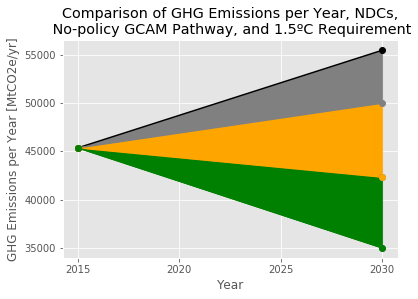

In [37]:
plt.plot(2015,ghgDf_PIK['2015'].sum()/convFactor,'o',
         2030,NDCs_clean.values.sum(),'o',
        2030,35000,'o')
plt.xticks(range(2010,2031,5))
plt.xlabel('Year')
plt.ylabel('GHG Emissions per Year [MtCO2e/yr]')
plt.title('Comparison of GHG Emissions per Year, NDCs,\n No-policy GCAM Pathway, and 1.5ºC Requirement')
 
x1 = [2015,2030]
y1 = [ghgDf_PIK['2015'].sum()/convFactor, ghgForecast_GCAM_BAU.loc['WLD','2030']/convFactor]
y2 = [ghgDf_PIK['2015'].sum()/convFactor, 50000]
y3 = [ghgDf_PIK['2015'].sum()/convFactor, NDCs_clean.values.sum()]
y4 = [ghgDf_PIK['2015'].sum()/convFactor, 35000]

CoeffLineNoPolicy = np.polyfit(x1,y1,1)
CoeffLineLowTarget = np.polyfit(x1,y2,1)
CoeffLineNDCs = np.polyfit(x1,y3,1)
CoeffLineHighTarget = np.polyfit(x1,y4,1)

LineNoPolicy = np.poly1d(CoeffLineNoPolicy)
LineLowTarget = np.poly1d(CoeffLineLowTarget)
LineNDCs = np.poly1d(CoeffLineNDCs)
LineHighTarget = np.poly1d(CoeffLineHighTarget)

plt.plot(x1, LineNoPolicy(x1), "-o", color = "black")
plt.plot(x1, LineLowTarget(x1), "-o", color = "grey")
plt.plot(x1, LineNDCs(x1), "-o", color = "orange")
plt.plot(x1, LineHighTarget(x1), "-o", color = "green")

plt.fill_between(x1, LineNoPolicy(x1), LineLowTarget(x1), color = "grey")
plt.fill_between(x1, LineLowTarget(x1), LineNDCs(x1), color = "orange")
plt.fill_between(x1, LineNDCs(x1), LineHighTarget(x1), color = "green")
plt.xticks(range(2015, 2031, 5))
plt.show()


## 2. Which countries should do more to combat climate change?

### 2.1 Top 20 greenhouse gas emitters

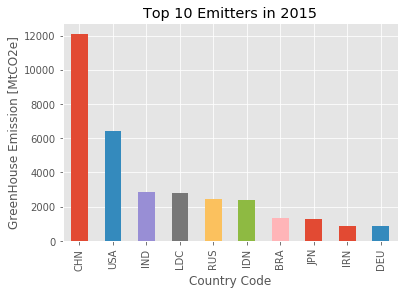

In [38]:
# Sorted bar chart of 2012 greenhouse gases

GHGTop10 = ghgDf_PIK.sort_values(by = "2015", ascending = False).iloc[:10,:]
GHGTop10["2015"].plot(x=ghgDf_PIK.index, kind="bar")

plt.ylabel("GreenHouse Emission [MtCO2e]")
plt.title('Top 10 Emitters in 2015')
plt.show()

### 2.2 Top 10 Polluters by pledged NDCs

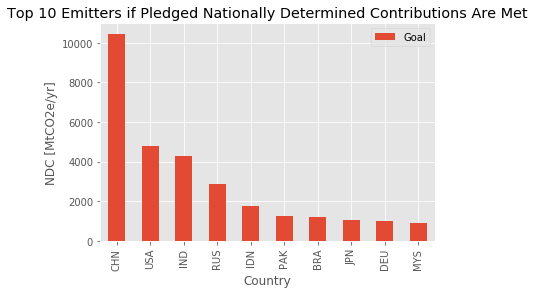

In [39]:
# Greenhouse reductions by countries according to their NDCs. Data is already converted to MtCO2e.
# Countries have different goals in terms of which year they are based on and which year they aim to meet
# those reductoin. Goals are also given as unconditional and conditional goals. Here the goals are  
# not based on year target but the minimum goal of each country is chosen.

# See who the top 10 polluters are going to be once NDCs are met
NDCsTop10 = NDCs_clean.sort_values(by="Goal", ascending=False)[:10]

NDCsTop10.plot(kind="bar")
plt.ylabel("NDC [MtCO2e/yr]")
plt.title("Top 10 Emitters if Pledged Nationally Determined Contributions Are Met")
plt.show()

Note that: IND-India and IDN-Indonesia.

In the first graph we observed that China, US and India are the top 3 major polluters. Even after NDCs are met, they will remain as the world's top three polluters. Among these countries even though Indonesia is the least polluting among these, it has higher reduction goals than many of the rest of the countries. 

### 2.3 2030 Projected Emissions vs. Emissions with NDCs Achieved

It would be interested to see how projected emissions match with NDCs and to then see who is reducing the most.

In [40]:
GHGTop10.index.values

array(['CHN', 'USA', 'IND', 'LDC', 'RUS', 'IDN', 'BRA', 'JPN', 'IRN',
       'DEU'], dtype=object)

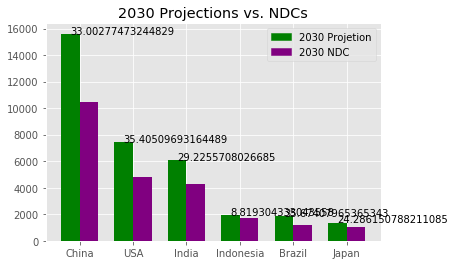

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


ValueError: Image size of 125410671x252 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [53]:
from numpy import array
import matplotlib.patches as mpatches

# Filter the top current emitters that was determined according to World Bank data who also have a projection.

top6Forecast = ghgForecast_GCAM_BAU.reindex(GHGTop10.index.values).dropna()
top6Forecast_sorted = top6Forecast["2030"].sort_values(ascending=False)

# NDCs of the top 10 current countries. 

NDCsTop10 = NDCsTop10.sort_values(by="Goal", ascending=False)

# Values to use in the graph. Missing countries are dropped from NDC list. 

y1 = top6Forecast_sorted.values

# y2=NDCsTop10[NDCsTop10['Country']!= "RUS"][NDCsTop10['Country']!= "DEU"][NDCsTop10['Country']!= "COD"]["Goal"].values
y2 = NDCsTop10[ NDCsTop10.index.isin(top6Forecast.index) ]["Goal"].values

x = np.arange(len(y1))

# Plot bar-chart for the 6 countries. 

bar_width = 0.35 
plt.bar(x,y1,width=bar_width,color="green")
plt.bar(x+bar_width,y2,width=bar_width,color="purple")

plt.xticks(x+bar_width/2,["China","USA","India","Indonesia","Brazil","Japan","Canada"])
plt.title("2030 Projections vs. NDCs")

green_patch=mpatches.Patch(color="green",label="2030 Projetion")
purple_patch=mpatches.Patch(color="purple",label="2030 NDC")
plt.legend(handles=[green_patch,purple_patch])

#The amount that countries need to reduce:    

difference=[]
for i in range(len(y1)):
    difference.append((y1[i]-y2[i])*100/y1[i])

for i in range(len(y1)):  #This looks ugly now, we can fix it. 
    plt.text(x=x[i],y=y1[i],\
         s = difference[i])

plt.show()

for i in range(len(list(HistoricalDebtMergedDf.index))):
    plt.text(x=HistoricalDebtMergedDf.ix[i,"Cummulative Emissions"],y=HistoricalDebtMergedDf.ix[i,"% reduction"],\
         s = list(HistoricalDebtMergedDf.index)[i])

### 3. Historical responsibility for climate change

#### Is it fair to put the same burden of greenhouse reduction on developing countries considering the historical emissions produced by developed countries?

Developing countries and international advocacy organization have argued that owing to their historical emissions, the developed countries owe a "climate debt" to poor countries (Pickering & Barry, 2012). The developed countries have enjoyed the fruit of industrial development way before the developing countries, and have used more than their fair share of Earth's ability to absorb greenhouse gases. Now, the call for reducing global emissions to combat climate change constrains the development of developing countries. Therefore, the developed countries should repay the climate debt by rapdily reducing their emissions and providing financial support to developing countries to upgrade their technologies (Pickering & Barry, 2012). 

The UNFCCC acknowledges this point of contention through the principle of Common but Differentiated Responsibilities and Respective Capabilities (CBDR–RC) stating that the countries should *"protect the climate system for the benefit of present and future generations of humankind, on the basis of equity and in accordance with their common but differentiated responsibilities and respective capabilities"* thereby urging the developed countries to take the lead on climate action (UNFCCC, 1992). The Paris Agreement also reaffirmed this obligation of developed countries.

However, the developed countries have argued to revise the crude 1992 definition of developing countries that sees 6 out of the 10 richest nations of the world as 'developing'. They have stressed that countries who are in a position to contribute financially should do so. 

This section analyses the cumulative historical emissions of the top polluters of the world and throws light on the their NDC reductions in relation to the cummulative emissions and GDP per capita. Further, the countries' contribution to the Green Climate Fund is analyzed to understand if the historical polluters are doing their bit to support climate mitigation in the developing countries.

References:
UNFCCC. (1992). United Nations Framework Convention on Climate Change. Retrieved from http://unfccc.int/files/essential_background/convention/background/application/pdf/convention_text_with_annexes_english_for_posting.pdf

Pickering, J., & Barry, C. (2012). On the concept of climate debt: Its moral and political value. Critical Review of International Social and Political Philosophy, 15(5), 667–685. https://doi.org/10.1080/13698230.2012.727311

The Telegraph. 2018. What is the Paris Agreement on climate change? Everything you need to know. https://www.telegraph.co.uk/business/0/paris-agreement-climate-change-everything-need-know/

### 3.1 Carbon Debt

Which countries are the major emitters of greenhouse gases considering the emissions from the year 1850?

In [42]:
CO2From1850_CAIT = pd.read_excel("data/wri/CW_CAIT_GHG_Emissions_31102017_ISO.xlsx", sheet_name="CO2 Total Emissions",\
                                 index_col = "ISO")
CO2From1850_CAIT.index.rename("Country Code", inplace=True)
CO2From1850_CAIT.fillna(value = 0, inplace=True)
CO2From1850_CAIT.drop(columns = "Country", inplace = True)
CO2From1850_CAIT.head()

,Year,Total CO2 Emissions Excluding Land-Use Change and Forestry (MtCO2)
Country Code,,
AFG,1850,0.0
ALB,1850,0.0
DZA,1850,0.0
AND,1850,0.0
AGO,1850,0.0


In [43]:
CO2From1850_CAIT = CO2From1850_CAIT.pivot_table(values = "Total CO2 Emissions Excluding Land-Use Change and Forestry (MtCO2)",\
                                                index = "Country Code", columns = "Year")
CO2From1850_CAIT["Cummulative Emissions"] = CO2From1850_CAIT.sum(axis=1)
CountriesHighHistDebt = CO2From1850_CAIT.sort_values(by = "Cummulative Emissions", ascending=False).iloc[:15, :]
CountriesHighHistDebt = CountriesHighHistDebt[["Cummulative Emissions"]]
CountriesHighHistDebt.drop(index= ["WORLD", "EU28"], inplace=True) 

CountriesHighHistDebt.head()

Year,Cummulative Emissions
Country Code,
USA,374583.671939
CHN,168761.753480
RUS,105235.562651
DEU,86024.739144
GBR,71280.958387


Text(0, 0.5, 'MTCO2')

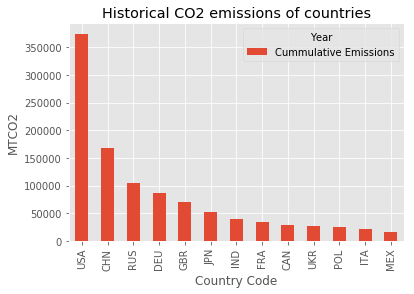

In [44]:
CountriesHighHistDebt.plot(kind="bar", title = "Historical CO2 emissions of countries")
plt.ylabel("MTCO2")

The above plot shows that USA has been the major historical emitter of greenhouse gases followed by China, Russia, Germany and the Great Britain. 

### 3.2 Time series for greenhouse gases of major (top 10 depending on V1) present polluters (from 1990 to most-recent)

### This graph needs to be redone till 2014

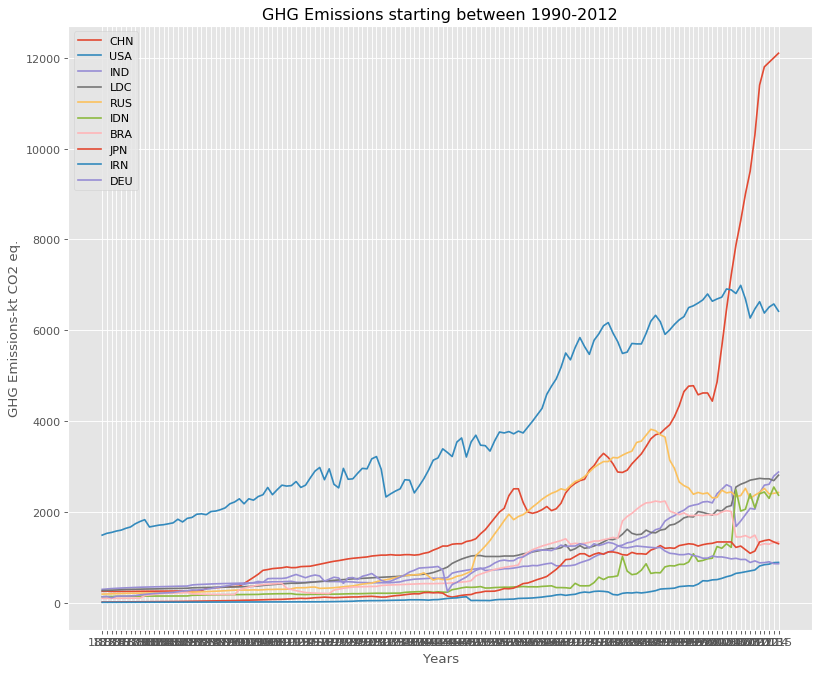

In [45]:
# Time series for ghg emissions of the top 10 most polluting countries.
plt.figure(figsize=(12, 10), dpi=80) 

for i in range(0,10):
    
    row = GHGTop10.iloc[i,22:-1]
    plt.plot(row)

plt.MaxNLocator(10)
plt.xlabel("Years")
plt.ylabel("GHG Emissions-kt CO2 eq.")
plt.title("GHG Emissions starting between 1990-2012")
plt.legend(loc=((1.05,0.3)))#how to show country names instead of the numbers 
plt.legend(GHGTop10.index)

plt.show()

We observe that the top polluter of the world China has increasing emissions starting from 1990s till 2012. The second polluter US, on the other hand shows a stable curve over the years. Until 2004 it is the top polluter of the world. India........

### 3.3 Relation between historical debt, % reduction in greenhouse gases promised and GDP per capita
How does the historical debt relate to countries' present GDP per capita (2018 values, `https://data.worldbank.org/indicator/NY.GDP.PCAP.CD`) and the % reduction in greenhouse gases promised for the year 2030?

In [46]:
#Random values of % reduction in historical debt to generate data for making the scatter plot
CountriesHighHistDebt["% reduction"] = np.random.uniform(size = len(CountriesHighHistDebt.index))

GDPperCapitaWB = pd.read_csv("data/world bank/GDP_per_capita.csv", skiprows=4, index_col = "Country Code", header = 0)
GDPperCapitaWB.dropna(how="all", axis=0, inplace=True)
GDPperCapitaWB.dropna(how="all", axis=1, inplace=True)
GDPperCapitaWB.drop(columns = ["Indicator Name","Indicator Code"], inplace = True)
GDPperCapitaWB.iloc[:,1:] = GDPperCapitaWB.iloc[:,1:].interpolate(axis = 1)
GDPperCapitaWB.head()

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country Code,,,,,,,,,,,,,,,,,,,,,
ABW,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27546.899390,24631.434860,24271.940421,25324.720362,25324.720362,25324.720362,25324.720362,25324.720362,25324.720362,25324.720362
AFG,Afghanistan,59.777327,59.878153,58.492874,78.782758,82.208444,101.290471,137.899362,161.322,129.506654,...,373.361116,445.893298,553.300289,603.537023,669.009051,638.612543,629.345250,569.577923,561.778746,585.850064
AGO,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3868.579014,3347.844900,3531.416878,4299.008136,4539.467689,4804.633826,4707.578098,3683.552607,3308.772828,4170.312280
ALB,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4370.539647,4114.136545,4094.358832,4437.178068,4247.614308,4413.081697,4578.666728,3952.830781,4131.872341,4537.862492
AND,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47785.659086,43339.379875,39736.354063,41098.766942,38391.080867,40619.711298,42294.994727,36038.267604,37231.815671,39146.548836


In [47]:
GDPperCapita2017 = GDPperCapitaWB[["2017"]]
GDPperCapita2017.head()

,2017
Country Code,
ABW,25324.720362
AFG,585.850064
AGO,4170.312280
ALB,4537.862492
AND,39146.548836


In [48]:
#Merge the two datasets here based on the Country Name
HistoricalDebtMergedDf = CountriesHighHistDebt.join(GDPperCapita2017)
HistoricalDebtMergedDf

,Cummulative Emissions,% reduction,2017
Country Code,,,
USA,374583.671939,0.503513,59531.661964
CHN,168761.753480,0.391210,8826.994096
RUS,105235.562651,0.486505,10743.096592
DEU,86024.739144,0.229271,44469.909061
GBR,71280.958387,0.296988,39720.443427
JPN,52688.201461,0.476820,38428.097317
IND,39332.372808,0.066665,1939.612984
FRA,34596.703776,0.720512,38476.658636
CAN,29101.492405,0.403514,45032.119908


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


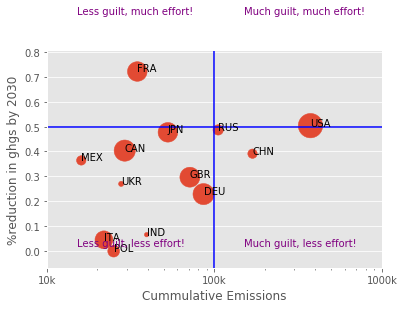

In [49]:
plt.scatter(x=HistoricalDebtMergedDf["Cummulative Emissions"],y=HistoricalDebtMergedDf["% reduction"],\
            s = HistoricalDebtMergedDf["2017"]/100)
plt.xscale("log")
plt.xlabel("Cummulative Emissions")
plt.ylabel("%reduction in ghgs by 2030")
for i in range(len(list(HistoricalDebtMergedDf.index))):
    plt.text(x=HistoricalDebtMergedDf.ix[i,"Cummulative Emissions"],y=HistoricalDebtMergedDf.ix[i,"% reduction"],\
         s = list(HistoricalDebtMergedDf.index)[i])
plt.grid(True)
plt.xticks([10000,100000,1000000], ["10k","100k", "1000k"])

#Divide horizontally
plt.axhline(y=0.5, color='b')

#Divide vertically
plt.axvline(x=100000, color='b')

# The graph is shifted when we do this, I commented. 
# Divide Vertically 

#t1 = np.arange(0.0, 5.0, 0.1)
#len(t1)

#L1=[]
#for i in range(len(t1)):
    #L1.append(800000)
    
#plt.plot(L1,t1)


# Divide Horizontally

#t1 = np.arange(0.0, 5.0, 0.1)
#len(t1)

#L1=[]
#for i in range(len(t1)):
    #L1.append(2.5)
    
#plt.plot(t1,L1)


#To divide into four something like. 

plt.text(x=150000, y=0.95, s="Much guilt, much effort!", color = 'purple')
plt.text(x=15000, y=0.95, s="Less guilt, much effort!", color = 'purple')
plt.text(x=15000, y=0.02, s="Less guilt, less effort!", color = 'purple')
plt.text(x=150000, y=0.02, s="Much guilt, less effort!", color = 'purple')

plt.show()

### 3.4 Green Climate Fund Pledges

The Green Climate Fund (GCF) is an international fund set up through the UNFCCC to help developing nations build projects that align with global emissions reduction goals. Projects include those for renewable elecricity, reducing 

All pledges made by countries are [listed online](https://www.greenclimate.fund/how-we-work/resource-mobilization) in an interactive table but does not provide the data cleanly. The site Our World in Data periodically scrapes this information and [compiles it](https://ourworldindata.org/grapher/green-climate-gcf-fund-pledges) into a .csv dataset, which is what we are going to import.

In [50]:
# From visual inspection, the column 'Year' and index 'World' is not necessary
gcfDf = pd.read_csv('data/green-climate-gcf-fund-pledges.csv',index_col=0).drop(columns='Year').drop('World')

# Rename the columns to be more readable and index name to be 'Country' instead of 'Entity'
gcfDf = gcfDf.rename(columns={'Code':'Country Code',
                      'Signed pledges (GCF) (US$ per year)':'Pledges'})
gcfDf.index.name = 'Country'

# Check the data
gcfDf.head()

,Country Code,Pledges
Country,,
Australia,AUS,187000000.0
Austria,AUT,34800000.0
Belgium,BEL,66900000.0
Bulgaria,BGR,100000.0
Canada,CAN,277000000.0


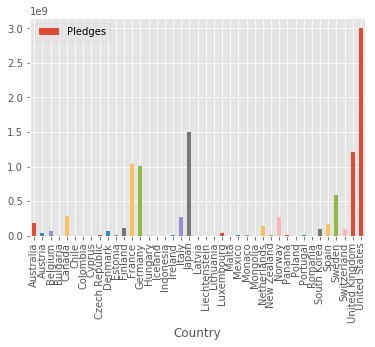

In [51]:
gcfDf.plot.bar(by='Country',y='Pledges')
plt.show()

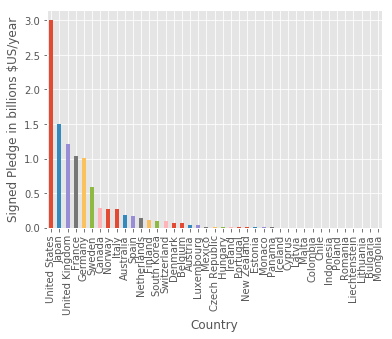

In [52]:
gcfDf['Pledges'].divide(1e9).sort_values(ascending=False).plot.bar(by='Pledges')
plt.ylabel('Signed Pledge in billions $US/year')
plt.show()